In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
print(np.__version__)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
import re
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
%matplotlib inline

2.0.0
1.18.1


Using TensorFlow backend.


https://www.kaggle.com/ozlerhakan/spam-or-not-spam-dataset

ทำการโหลดดาต้ามาเก็บ

In [6]:
data = pd.read_csv('spam_or_not_spam.csv')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


จะเห็นได้ว่าข้อมูลของ ham จะมีมากกว่า spam อยู่มาก

Text(0.5, 1.0, 'Number of ham and spam messages')

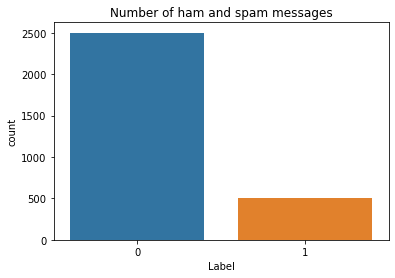

In [7]:
sns.countplot(data.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

เรานั้นวิธีการปรับปรุงมากจาก https://www.kaggle.com/shivammehta007/spam-not-spam-classifier-with-pytorch

fit_on_texts ทำหน้าที่ แปลงข้อมูล “หลาย ๆ ประโยค” จาก data ให้เป็นคำ ๆ โดยแยกคำด้วย “เว้นวรรค” และกำหนด Index ให้แต่ละคำ (word_index) โดย “เรียงตามความถี่

เนื่องจากขั้นตอนที่จะไปแปลงเป็น fit_on_texts มีความผิดพลาดเนื่องจากdata ยังไม่ดีพอ

In [8]:
data.dropna(inplace=True)
change_labels = lambda x: 1 if x==0 else 0
data['label'] = data['label'].apply(change_labels)
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,1
1,martin a posted tassos papadopoulos the greek ...,1
2,man threatens explosion in moscow thursday aug...,1
3,klez the virus that won t die already the most...,1
4,in adding cream to spaghetti carbonara which ...,1


ทำการเตรียมกระบวนการในการทำสิ่งต่างๆ

ปรับข้อมูลให้เหลือแค่ตัวอักษร a-z 

In [9]:
remove_non_alphabets =lambda x: re.sub(r'[^a-zA-Z]',' ',x)

เปลี่ยนข้อมูลให้ตัดเป็นคำๆแล้วใส่ในลิส

In [10]:
tokenize = lambda x: word_tokenize(x)

เปลี่ยนเป็น ver ช่อง 1 

In [11]:
ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

เปลี่ยนเป็นคำที่มีความหมายคล้ายกันแต่มีความนิยมในการใช้มากว่า

In [12]:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

เอากระบวนการทำงานต่างๆมาใช้

In [9]:
print('Processing : [=', end='')
data['email'] = data['email'].apply(remove_non_alphabets)
print('=', end='')
data['email'] = data['email'].apply(tokenize) # [ word_tokenize(row) for row in data['email']]
print('=', end='')
data['email'] = data['email'].apply(stem)
print('=', end='')
data['email'] = data['email'].apply(leammtizer)
print('=', end='')
data['email'] = data['email'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')
data.head()

Processing : [=====] : Completed

,email,label
0,date wed number aug number number number numbe...,1
1,martin a post tasso papadopoulo the greek scul...,1
2,man threaten explos in moscow thursday august ...,1
3,klez the viru that won t die alreadi the most ...,1
4,in ad cream to spaghetti carbonara which ha th...,1


In [10]:
df = data
X = df.email
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

สลับค่า 0 กับ 1

In [11]:
for i in range(len(Y)):
    if Y[i]==0:
        Y[i]=1
    elif Y[i]==1:
        Y[i]=0

In [20]:
X[2]

'man threaten explos in moscow thursday august number number number number pm moscow ap secur offic on thursday seiz an unidentifi man who said he wa arm with explos and threaten to blow up hi truck in front of russia s feder secur servic headquart in moscow ntv televis report the offic seiz an automat rifl the man wa carri then the man got out of the truck and wa taken into custodi ntv said no other detail were immedi avail the man had demand talk with high govern offici the interfax and itar ta news agenc said ekho moskvi radio report that he want to talk with russian presid vladimir putin polic and secur forc rush to the secur servic build within block of the kremlin red squar and the bolshoi ballet and surround the man who claim to have one and a half ton of explos the news agenc said negoti continu for about one and a half hour outsid the build itar ta and interfax report cite wit the man later drove away from the build under polic escort and drove to a street near moscow s olymp 

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

กำหนดจำนวนคำทั้งหมดที่จะใช้ในการเรียนรู้ max_words เลือกจากคำที่มีความถึ่สูงสุด 2000 อันดับแรก จำนวนคำที่จะใส่เข้าไปในแต่ละชุดว่ามีชุดละกี่คำ max_len  sหลังจากนั้นนำไปแปลให้อยู่ในรูปแบบ เมตริก sequences_matrix

In [16]:
max_words = 2000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [19]:
len(sequences_matrix)

2399

ใน layers แรกเราจะกำหนดขนาดของข้อมูลในแต่ละชุด

keras.layers.Embedding ทำการให้layer นี้หารูปแบบความสัมพันธ์ว่าแต่ละคำมีลักษณะอย่างไงโดยที่เราจะไม่รู้ภายในเราจึงกำหนดให้มี 60 ฟีเจอร์ เนื่องจากในงานนี้อีก model ที่เป็นตัวอย่าง model นี้ใช้ 50 แต่อันนั้นดาต้าที่ใช้มีคำมีน้อยเราจึงเพิ่มมากอีก 10 เพื่อให้มันทำการแยกลักษณะได้ชัดเจนยิ่งขึ้น

keras.layers.LSTM หรือ Long Short-Term Memory เราจะให้มีสัก 64 เนื่องจากเราไม่อยากให้มีมากเกินเพราะไม่จำเป็นเนื่องจากข้อมูลที่เราให้มาในหนึ่งชุดเราจึงใช้เพียงเท่านี้ก็พอ

keras.layers.Dropout(0.5), 
keras.layers.Dense(64,activation=tf.nn.relu), เนื่องจากเราไม่ต้องการใ้ห้มันเกิดการ overfit เราจึงใส่ Dropout(0.5) หรือทำการสุ่มปิดโหนด 50% นั้นหมายความว่าโหนดจะถูกปิดไปเหลือ 32 ซึ่งแปลว่าจะมีบางรอบที่ค่าในโหนดที่ถูกปิดจะไม่มีการปรับแล้ว(ทำมัยไม่ใช้เป็น 32เพราะอย่างไรเราก็จะปิดครึ่งนึง) เพราะเราใช้ 32 มันจะมีน้อยเกินไปที่จะเกินการเรียนรู้และการที่มันถูกปิดครึ่งนึงไม่ได้หมายความว่าประสิทธิภาพจากลดลงครึ่งนึง และเรายีงใช้ฟังชัน relu เพื่อลดการมองระละเอียดที่มากเกินไปกล่าวคือลักษณะมนุษย์หากมีบางสิ่งบางอย่างที่เราสัมผัสได้น้อยมากร่างกายจะตัดสิ่งนั้นออกไปโดยที่เราไม่รูตัวเช่นการหายใจทำให้เกิดเสียงเราแต่มะน้อยมากเราจึงไม่รับรู้การได้ยินเสียงหายใจ และในทางคอมพิวเตอร์ได้ทำการเปลี่ยนฟังชั่นให้การเป็นรูปแบบเส้นตรง

keras.layers.Dropout(0.4),
keras.layers.Dense(32,activation=tf.nn.relu), เกิดจากที่ว่าหากเราจริงให้มีแค่ 64 ยังไม่มากพอเราจึงขอเพิ่มเป็น 32 เพื่อให้มันเกิดการวิเคราะห์ที่มากขึ้นและใส่ Dropout(0.4) หรือ 40%  


keras.layers.Dense(1,activation=tf.nn.sigmoid) ในชั้นสุดท้ายเราจะเลือกให้เป็น 1 เพราะมีคำตอบแค่เป็นหรือไม่เป็น ham หรือ spam และยังให้ activation=tf.nn.sigmoid เราเลือกเป็น sigmoid เนื่องจาก Output ของ Sigmoid Function มีค่าระหว่าง 0 – 1 จึงเหมาะที่จะถูกใช้ในงานที่ต้องการ Output เป็นความน่าจะเป็น (Probability) หรือใช้เป็น Output ว่า 1=Yes, 0=No
เราใช้ binary_crossentropy เพราะเราทำงานแยกประเภทแค่ 2 class 

เราจะใช้ optimizer เป็น RMSprop วิธีนี้จะเก็บค่าเกรเดียน ของครั้งก่อนนำมาใช้ในรอบการเรียนรู้ปัจจุบัน และนำไปปรับปรุงอัตราส่วนการเรียนรู้่ โดยมีการใช่ค่าความคลาดเคลื่อนกำลังสองเฉลี่ย (Mean Square Error)สำหรับเก็บค่าอัตราการเรียนรู้

In [179]:
model = keras.Sequential([
  


keras.layers.Input(name='inputs',shape=[max_len]),
    
keras.layers.Embedding(max_words,60,input_length=max_len),
keras.layers.LSTM(64),

keras.layers.Dropout(0.5),

keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32,activation=tf.nn.relu),
keras.layers.Dropout(0.6),
keras.layers.Dense(1,activation=tf.nn.sigmoid)

])
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 60)           120000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                32000     
_________________________________________________________________
dropout_36 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_37 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_38 (Dropout)         (None, 32)              

เราจะทำการฝึก model เราแบ่ง 20% จากตัวฝึกเป็นตัวทดสอบเราย่อยกลุ่มให้มันทำงานพร้อมกัน 16 กลุ่มการทำงานเนื่องจากเราต้องการเซ็ตค่ากลุ่มย่อยการทำงานซึ่งเดิมทีหากเราไม่ใส่อะไรให้เป็นค่าเริ่มจะเท่ากับ 32 มันจะมีผลคือทุกครั้งที่ทำครบ 32 เราจะเริ่มปรับค่าในโหนดซึ่งจำนวนครั้งการปรับมีน้อยไปเราจึงอาจจะต้องใช้พวก learning rate มากจัดการแต่หากไม่พอเราต้องยอมให้การทำงานช้าขึ้นโดยการลดกลุ่มย่อย และเราได้ทำการสั้งให้ฝึก 20 epochs และใช้ค่า val_loss มาเป็นตัวบอกว่าควรจะหยุดหรือไม่เช่นหากไม่มีการปรับค่าที่ดีขึ้นเกินเท่านี้หรือค่ากลับแย่ลงเราจะทำการหยุดเหตุที่เราเลือกที่จะดูค่า loss เพราะหาดูแต่ความแม่นยำเราอาจจะได้เยอะเพราะตัวอย่างของสอง class มีปริมาณที่่ต่างกันมากหากมีนตอบถูกของ class ที่มีปริมาณมาแต่ดันตอบผิด class ที่มีปริมาณน้อยหมดเลย ก็จะยังได้ค่าที่ดีกล่าวคือยิ่งค่าแปรปรวนหรือส่นเบียงเบนยิ่งน้อยยิ่งดีนั้นหมายความว่าเรายิ่งได้คำตอบที่ใกล้เคียงเราจึงเลือกดูค่า loss ของตัวทดสอบ

In [180]:
h =  model.fit(sequences_matrix,Y_train,batch_size=16,epochs=20,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 1919 samples, validate on 480 samples
Epoch 1/20
1919/1919 [==============================] - 4s 2ms/sample - loss: 0.4287 - accuracy: 0.8390 - val_loss: 0.1365 - val_accuracy: 0.9667
Epoch 2/20
1919/1919 [==============================] - 3s 1ms/sample - loss: 0.1141 - accuracy: 0.9729 - val_loss: 0.0516 - val_accuracy: 0.9771
Epoch 3/20
1919/1919 [==============================] - 3s 1ms/sample - loss: 0.0490 - accuracy: 0.9885 - val_loss: 0.0350 - val_accuracy: 0.9875
Epoch 4/20
1919/1919 [==============================] - 3s 1ms/sample - loss: 0.0710 - accuracy: 0.9911 - val_loss: 0.0489 - val_accuracy: 0.9875


เราจะเห็นว่าค่า val_accuracy ของ test จะทำได้ใกล้เคียง accuracy ของ train ไม่เกิดปัญหา overfit

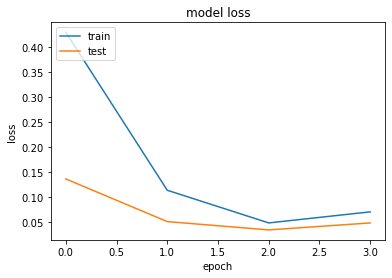

In [181]:
import matplotlib.pyplot as plt
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

เราจะเห็นว่าค่า val_accuracy ของ test จะทำได้ใกล้เคียง accuracy ของ train ไม่เกิดปัญหา overfit

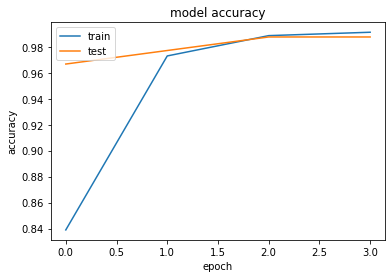

In [182]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

หลังจากนั้นนำข้อมูลที่เราแยกไว้สำหรับการทดสอบนำมาใช้

In [183]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

จากนั้นนำมาหา CONFUSION MATRIX เราจะให้ 1 เป้น Positive และ 0 เป็น Negative กล่าวคือให้ spam เป็น Positive และ ham เป็น Negative <br />
spam มี  98 <br />
ham มี  502<br />
เป็น spam แล้วตอบถูก :  94<br />
เป็น spam แล้วตอบว่าเป็น ham :  4<br />
เป็น ham แล้วตอบถูก :  501<br />
เป็น ham แล้วตอบว่าเป็น sham :  1<br />
เราจะได้ค่า Accuracy ที่สูงเนื่องจาก ham มีปริมาณที่มากกว่าและยังตอบถูกมากว่า spam <br />
Accuracy รวมการตอบที่ถูกทั้งหมดมาคิดกับปริมาณข้อมูลทั้งหมด<br />
Accuracy (ความถูกต้อง) = (TPs + TNs) / (TPs+TNs+FPs + FNs)<br />
Precision คือการคำนวณเทียบกับคำตอบที่ผิดข้างเคียง ว่า spam ถูกมากน้อยแค่ไหน<br />
Precision = tp / (tp + fp)<br />
Recall คือความถูกต้องของการทำนายว่าจะเป็น “spam” เทียบกับ จำนวนครั้งของเหตุการณ์ทั้งทำนาย และ เกิดขึ้นว่า “เป็นspam” กล่าวคือ นำผลที่ตอบว่า spam แล้วถูกหารกับผลที่ตอบว่า spam ทั้งหมดรวมกัน<br />
F1-Score เป็นค่าเฉลี่ยแบบ harmonic mean ระหว่าง precision และ recall จุดประสงค์ของการสร้าง F1 ขึ้นมา คือ เพื่อเป็น single metric ที่วัดความสามารถของโมเดล
F1 = 2 x (Precision x Recall)/(Precision + Recall)


In [189]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_sequences_matrix)

acc = accuracy_score(Y_test, np.round(preds))*100
cm = confusion_matrix(Y_test, np.round(preds)) 
tn, fp, fn, tp = cm.ravel()
print('เป็น spam แล้วตอบถูก : ',tp)
print('เป็น spam แล้วตอบว่าเป็น ham : ',fp)
print('เป็น ham แล้วตอบถูก : ',tn)
print('เป็น ham แล้วตอบว่าเป็น sham : ',fn)

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((h.history['accuracy'][-1])*100, 2)))

เป็น spam แล้วตอบถูก :  94
เป็น spam แล้วตอบว่าเป็น ham :  4
เป็น ham แล้วตอบถูก :  501
เป็น ham แล้วตอบว่าเป็น sham :  1
CONFUSION MATRIX ------------------
[[501   4]
 [  1  94]]

TEST METRICS ----------------------
Accuracy: 99.16666666666667%
Precision: 95.91836734693877%
Recall: 98.94736842105263%
F1-score: 97.40932642487046

TRAIN METRIC ----------------------
Train acc: 99.11


หลังจากนั้นเราก็ประเมินผลโมเดล
ค่า loss ได้ 2.4% เป็นค่าที่ค่อนข้างดี 
ค่า Accuracy ได้ 99.2% เป็นค่าที่ดี
แต่ถ้าเราสังเกตุดูดีดีถ้าเทียบกับอีก data นึงจะเห็นได้ว่าการตอบผลของ spam มีความถูกต้องน้อยกว่า

In [190]:
accr = model.evaluate(test_sequences_matrix,Y_test)

600/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [191]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.024
  Accuracy: 0.992
